# Customer Lifetime Value Project – EDA Notebook 🧠📊

## Objective 📌

This notebook performs exploratory data analysis (EDA) on the customer purchase dataset, focusing on RFM (Recency, Frequency, Monetary, AveragePurchaseValue, CustomerLifespan, MeanDaysBetweenPurchases) features and deriving Customer Lifetime Value (CLV).

The goal is to understand customer purchasing behavior to support further modeling (e.g., churn prediction, segmentation, CLV regression).

---

## 1. Load RFM Data

In [2]:
import sys
import os
os.chdir("..")
# Добавляем src в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))


In [6]:
from src.data_preparation import prepare_data
print(prepare_data.load_raw_data.__code__.co_varnames)

('purchases', 'survey')


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from importlib import reload
#import src.data_preparation.prepare_data as prepare_data
#reload(prepare_data)
from src.data_preparation import prepare_data
from src.feature_engineering import engineer_features

# Load and clean data
purchases, survey = prepare_data.load_raw_data()
df = prepare_data.clean_data(purchases)

# Create features (cutoff set to '2022-01-01' inside the function)
rfm_df = engineer_features.create_rfm_features(df,
                             customer_id_col='Survey ResponseID',
                             invoice_date_col='Order Date',
                             amount_col='TotalPrice')

rfm_df.head()

,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases
Survey ResponseID,,,,,,
R_01vNIayewjIIKMF,2,130,4502.83,34.637154,1123,8.638462
R_037XK72IZBJyF69,3,962,13754.37,14.297682,1443,1.500000
R_038ZU6kfQ5f89fH,40,64,3914.00,61.156250,1109,17.328125
R_03aEbghUILs9NxD,3,147,3333.72,22.678367,1448,9.850340
R_06RZP9pS7kONINr,3,328,8254.94,25.167500,1438,4.384146


In [10]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4991 entries, R_01vNIayewjIIKMF to R_zfqnsBzlOAKibzb
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Recency                   4991 non-null   int64  
 1   Frequency                 4991 non-null   int64  
 2   Monetary                  4991 non-null   float64
 3   AveragePurchaseValue      4991 non-null   float64
 4   CustomerLifespan          4991 non-null   int64  
 5   MeanDaysBetweenPurchases  4991 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 272.9+ KB


## 2. Summary Statistics

In [11]:
rfm_df.describe()

,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases
count,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000
mean,45.205971,274.206171,6491.449487,26.386309,1299.845121,22.784088
std,133.269954,324.065624,7415.891649,14.760126,282.330690,64.604775
min,0.000000,1.000000,4.990000,4.081090,1.000000,0.417885
25%,2.000000,64.000000,1559.820000,18.801478,1288.000000,3.771480
50%,9.000000,169.000000,4159.060000,23.536456,1434.000000,7.707447
75%,24.000000,363.000000,8675.880000,29.900969,1454.000000,18.467949
max,1460.000000,3489.000000,86965.850000,289.920000,1460.000000,1447.000000


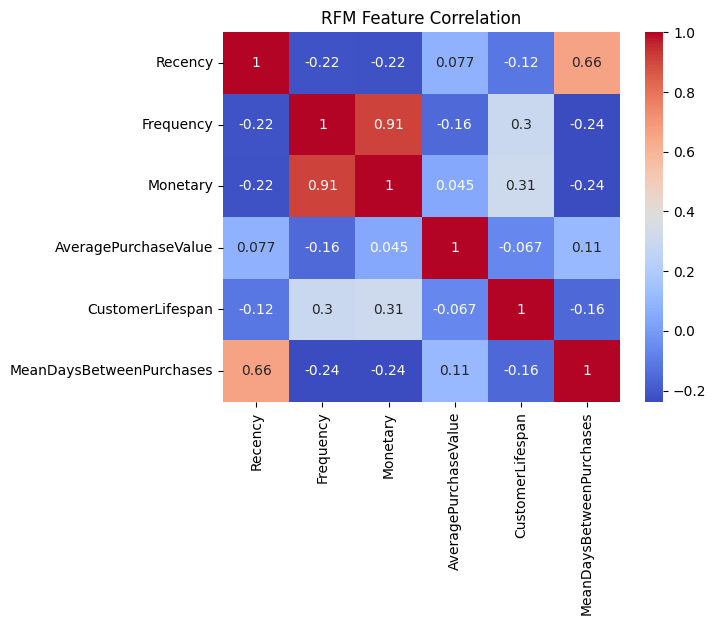

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(rfm_df.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlation")
plt.show()

## 3. Distributions

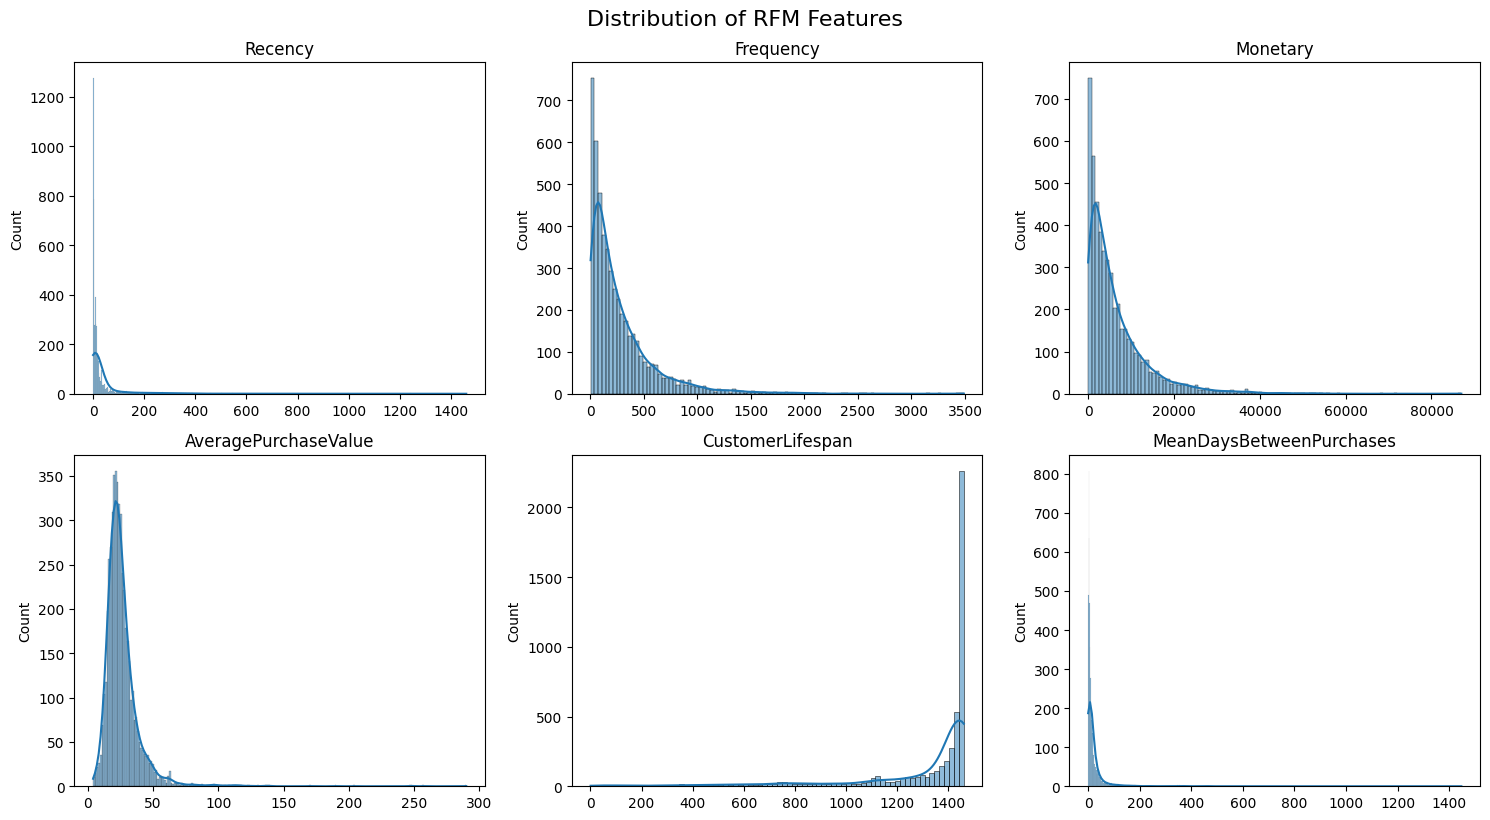

In [13]:
plt.figure(figsize=(15, 8))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_df[col], kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.tight_layout()

plt.suptitle("Distribution of RFM Features", fontsize=16, y=1.02)
plt.show()

## 4. Features outliers

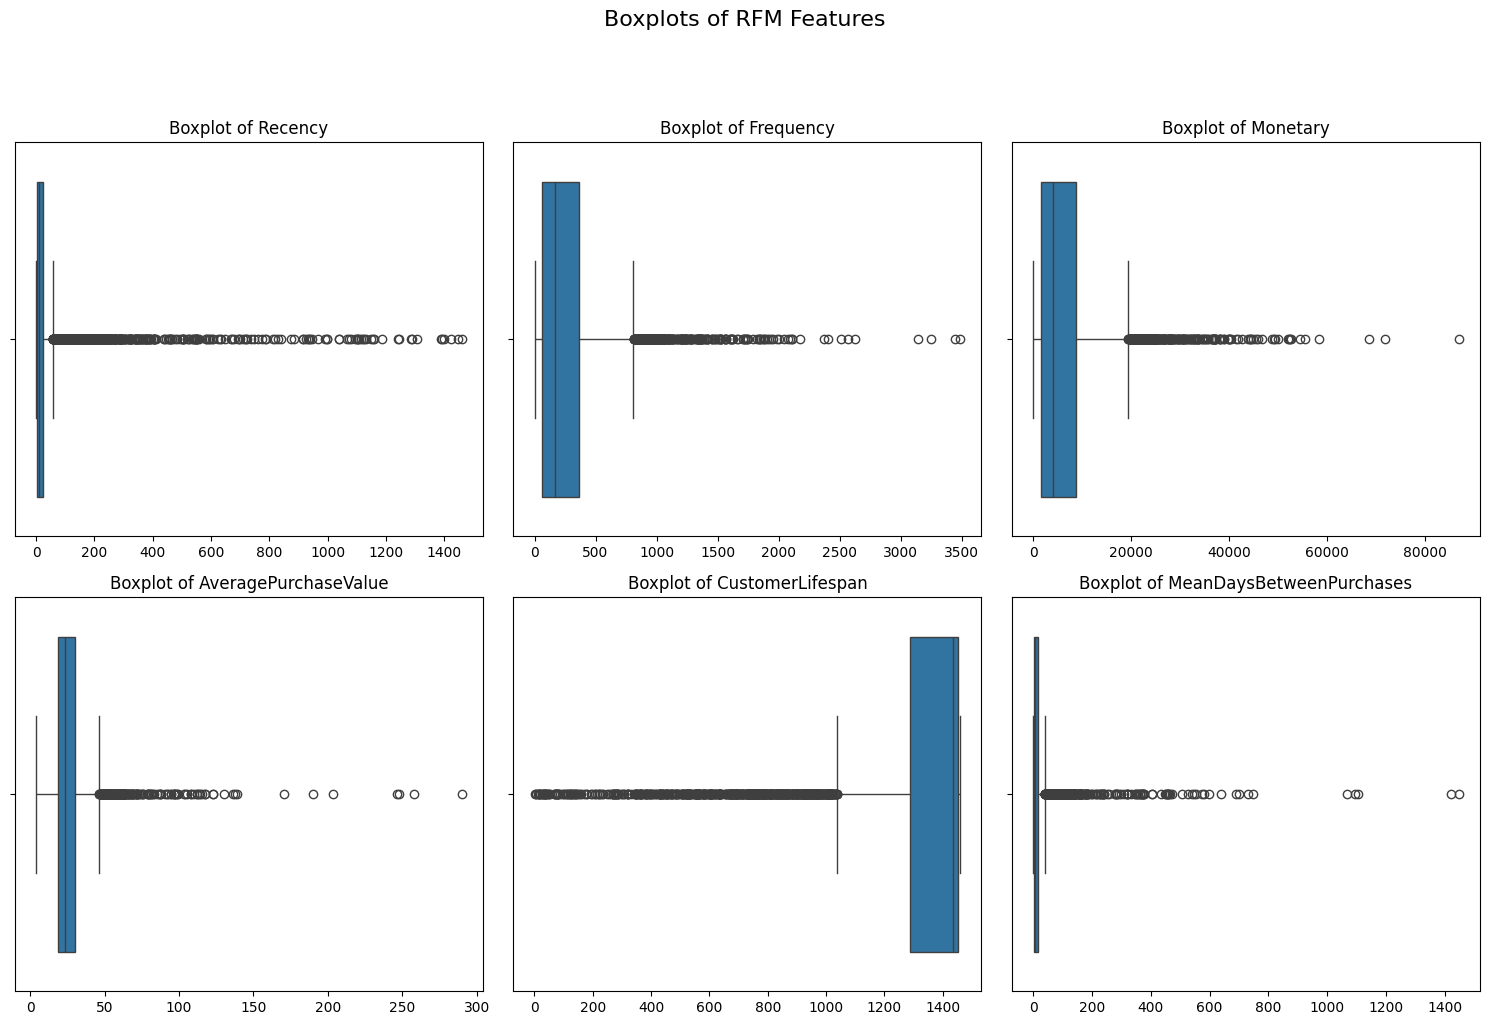

In [14]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=rfm_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.suptitle("Boxplots of RFM Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [15]:
import numpy as np

for col in rfm_df.columns:
    q1 = rfm_df[col].quantile(0.25)
    q3 = rfm_df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = rfm_df[(rfm_df[col] < (q1 - 1.5 * iqr)) | (rfm_df[col] > (q3 + 1.5 * iqr))]
    print(f'Outliers in {col}: {len(outliers)}')

Outliers in Recency: 692
Outliers in Frequency: 320
Outliers in Monetary: 301
Outliers in AveragePurchaseValue: 282
Outliers in CustomerLifespan: 645
Outliers in MeanDaysBetweenPurchases: 548


## 5. Feature Transformation

To address strong skewness and scale disparities among RFM features, we applied a mixed transformation strategy:

- **Logarithmic transformation** was applied to `Frequency`, `Monetary`, and `AveragePurchaseValue`, as they are strictly positive and heavily right-skewed.
- **Quantile transformation (normal output distribution)** was used for `Recency`, `CustomerLifespan`, and `MeanDaysBetweenPurchases`, which showed extreme skewness and high variance in scale. This method helps to approximate a normal distribution, making features more suitable for many machine learning models.

This combination balances interpretability and model-readiness.



In [19]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

# Копируем датафрейм
rfm_transformed = rfm_df.copy()

# 1. Log-transformation
log_cols = ['Frequency', 'Monetary', 'AveragePurchaseValue']
rfm_transformed[log_cols] = rfm_transformed[log_cols].apply(lambda x: np.log1p(x))

# 2. QuantileTransformer
skewed_cols = ['Recency', 'CustomerLifespan', 'MeanDaysBetweenPurchases']
qt = QuantileTransformer(output_distribution='normal', random_state=42)
rfm_transformed[skewed_cols] = qt.fit_transform(rfm_transformed[skewed_cols])


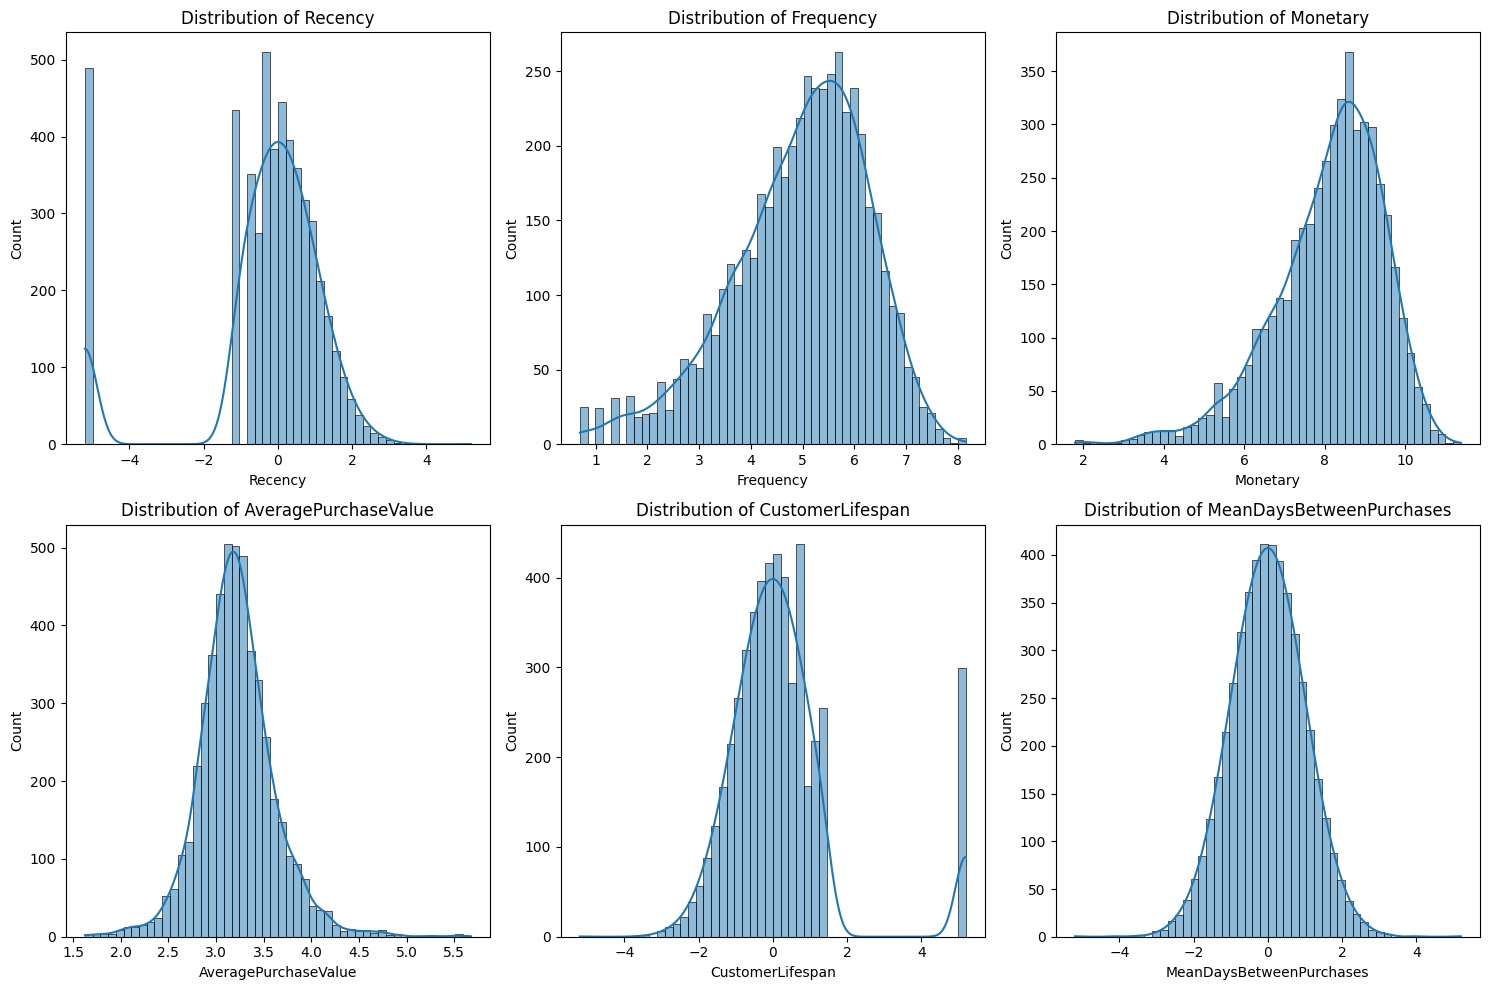

In [20]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(rfm_transformed.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_transformed[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## 6. CLV Feature Creation

We define CLV as Frequency × Monetary. This variable will be used as the target for future modeling.

In [33]:
log_rfm["CLV"] = log_rfm["Monetary"] * log_rfm["Frequency"]

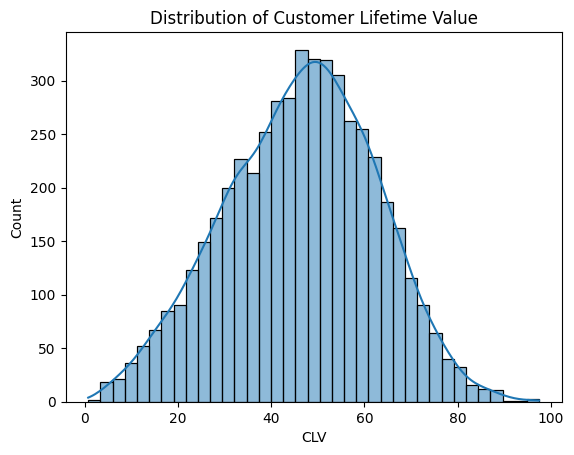

In [34]:
sns.histplot(log_rfm["CLV"], kde=True)
plt.title("Distribution of Customer Lifetime Value")
plt.show()

Text(0.5, 1.0, 'Boxplot of log(CLV)')

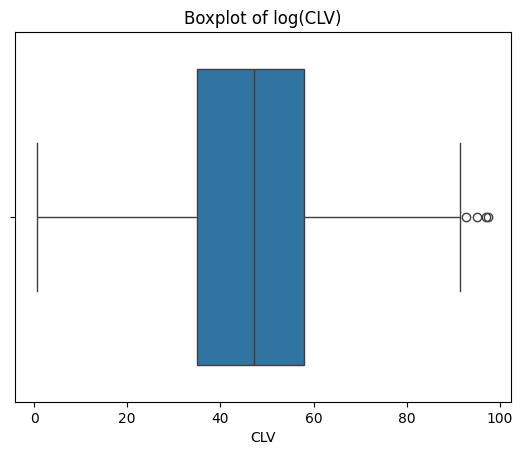

In [38]:
sns.boxplot(x=log_rfm["CLV"])
plt.title("Boxplot of log(CLV)")

## 7. Uploading Datase

In [ ]:
log_rfm.to_csv("data/processed/log_rfm_features.csv")